## 3. Predicció del preu:
### a. Es vol predir el preu dels diamants (de fet, el logaritme del preu escalat).

In [13]:
# Variables que no s'han d'utilitzar com a entrades
exclude_cols = ['id', 'price', 'log_price', 'log_price_scaled', 'high_price']

# Definim X i y
X_train = train_df_clean.drop(columns=exclude_cols)
y_train = train_df_clean['log_price_scaled']

X_test = test_df_clean.drop(columns=exclude_cols)
y_test = test_df_clean['log_price_scaled']


### b. S’han d’utilitzar els següents mètodes de predicció:
#### i. Regressió multilineal (MLR).

In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

mlr = LinearRegression()

# Cross-validation (5 folds) sobre l'entrenament
scores_mlr = cross_val_score(mlr, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
print("MAE mitjà (MLR - CV):", -scores_mlr.mean())

# Entrenament final sobre totes les dades d'entrenament
mlr.fit(X_train, y_train)
y_pred_mlr = mlr.predict(X_test)


MAE mitjà (MLR - CV): 0.024259000029335183


#### ii. K-Nearest Neighbors (k-NN).


In [15]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

# Busquem el millor valor de k
knn = KNeighborsRegressor()
param_grid = {'n_neighbors': list(range(3, 21))}

grid_knn = GridSearchCV(knn, param_grid, cv=5, scoring='neg_mean_absolute_error')
grid_knn.fit(X_train, y_train)

best_k = grid_knn.best_params_['n_neighbors']
print(f"Millor k: {best_k}, MAE mitjà (CV): {-grid_knn.best_score_:.5f}")

# Model definitiu
knn_final = KNeighborsRegressor(n_neighbors=best_k)
knn_final.fit(X_train, y_train)
y_pred_knn = knn_final.predict(X_test)

Millor k: 9, MAE mitjà (CV): 0.02749


#### iii. Multilayer Neural Network amb Back-Propagation (MLNN-BP).

In [16]:
from sklearn.neural_network import MLPRegressor

mlp = MLPRegressor(hidden_layer_sizes=(64, 32), activation='relu', max_iter=500, random_state=42)
scores_mlp = cross_val_score(mlp, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
print("MAE mitjà (MLP - CV):", -scores_mlp.mean())

# Model definitiu
mlp.fit(X_train, y_train)
y_pred_mlp = mlp.predict(X_test)

MAE mitjà (MLP - CV): 0.02243253806855765


### c. Utilitzeu cross-validation per a ajustar els paràmetres dels models, i un cop decidits els paràmetres, mesurar la qualitat prevista de la predicció. Tot això es fa sobre el conjunt d’entrenament proporcionat, que es dividirà en diferents subconjunts d’entrenament i validació en el procés de cross-validation.

In [17]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV
import numpy as np

#### Regressió Multilineal (MLR)

In [18]:
mlr = LinearRegression()
scores_mlr = cross_val_score(mlr, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
mae_mlr_cv = -scores_mlr.mean()
print(f"MAE mitjà (MLR - CV): {mae_mlr_cv:.5f}")

MAE mitjà (MLR - CV): 0.02426


#### K-Nearest Neighbors (k-NN)

In [19]:
param_grid_knn = {'n_neighbors': list(range(3, 21))}
grid_knn = GridSearchCV(KNeighborsRegressor(), param_grid_knn, cv=5, scoring='neg_mean_absolute_error')
grid_knn.fit(X_train, y_train)
best_k = grid_knn.best_params_['n_neighbors']
mae_knn_cv = -grid_knn.best_score_
print(f"Millor k: {best_k}, MAE mitjà (k-NN - CV): {mae_knn_cv:.5f}")

Millor k: 9, MAE mitjà (k-NN - CV): 0.02749


#### Multilayer Neural Network (MLNN-BP)

In [20]:
mlp = MLPRegressor(
    hidden_layer_sizes=(64, 32),
    activation='relu',
    max_iter=500,
    random_state=42
)
scores_mlp = cross_val_score(mlp, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
mae_mlp_cv = -scores_mlp.mean()
print(f"MAE mitjà (MLNN - CV): {mae_mlp_cv:.5f}")

MAE mitjà (MLNN - CV): 0.02243


### d. Un cop decidits els paràmetres i avaluada la qualitat prevista de la predicció, utilitzeu tot el conjunt d’entrenament per a ajustar el model predictiu definitiu que s’aplicarà al conjunt de test.
#### Model definitiu - Regressió Multilineal (MLR)

In [21]:
mlr_final = LinearRegression()
mlr_final.fit(X_train, y_train)
y_pred_mlr = mlr_final.predict(X_test)

#### Model definitiu - k-Nearest Neighbors (k-NN)

In [22]:
knn_final = KNeighborsRegressor(n_neighbors=best_k)
knn_final.fit(X_train, y_train)
y_pred_knn = knn_final.predict(X_test)

#### Model definitiu - Multilayer Neural Network (MLNN-BP)

In [23]:
mlp_final = MLPRegressor(
    hidden_layer_sizes=(64, 32),
    activation='relu',
    max_iter=500,
    random_state=42
)
mlp_final.fit(X_train, y_train)
y_pred_mlp = mlp_final.predict(X_test)

### e. La mesura de qualitat de la predicció que s’ha d’utilitzar és el Mean Absolute Percentage Error (MAPE), on 𝑦^𝜇 és la predicció i 𝑧^𝜇 el valor real corresponents al patró 𝜇-èssim. Aquests valors han de representar preus en USD ($), no els seus transformats utilitzats durant l’entrenament.

In [24]:
# Invertim l'escalat log_price_scaled → log_price
def inverse_scale_log_price(scaled_log_p):
    return min_log + (scaled_log_p - 0.1) * (max_log - min_log) / 0.8

# Convertim log_price → price en USD
def log_to_price(log_p):
    return np.exp(log_p)

# Destransformem les prediccions
price_pred_mlr = log_to_price(inverse_scale_log_price(y_pred_mlr))
price_pred_knn = log_to_price(inverse_scale_log_price(y_pred_knn))
price_pred_mlp = log_to_price(inverse_scale_log_price(y_pred_mlp))

# Valors reals de preus
price_real = test_df_clean['price'].values

# Fórmula del MAPE
def mape(y_true, y_pred):
    return 100 * np.mean(np.abs((y_pred - y_true) / y_true))

# Càlcul del MAPE per cada model
mape_mlr = mape(price_real, price_pred_mlr)
mape_knn = mape(price_real, price_pred_knn)
mape_mlp = mape(price_real, price_pred_mlp)

print(f"MAPE MLR: {mape_mlr:.2f}%")
print(f"MAPE k-NN: {mape_knn:.2f}%")
print(f"MAPE MLNN-BP: {mape_mlp:.2f}%")


MAPE MLR: 11.13%
MAPE k-NN: 12.02%
MAPE MLNN-BP: 9.18%


### f. Fer prediccions dels preus (en USD) sobre el conjunt de test per a cada model de predicció i analitzeu els resultats:
#### i. Calculeu el MAPE en el conjunt de test per a cada model.

In [25]:
# Mostrem els resultats finals de l'error de predicció
print("===== MAPE sobre el conjunt de test (preus en USD) =====")
print(f"MLR      → MAPE: {mape_mlr:.2f}%")
print(f"k-NN     → MAPE: {mape_knn:.2f}%")
print(f"MLNN-BP  → MAPE: {mape_mlp:.2f}%")

===== MAPE sobre el conjunt de test (preus en USD) =====
MLR      → MAPE: 11.13%
k-NN     → MAPE: 12.02%
MLNN-BP  → MAPE: 9.18%


#### ii. Genereu un dataframe amb els atributs originals més les prediccions dels tres models, amb noms pred_price_mlr, pred_price_knn, pred_price_bp.

In [27]:
# Copiem el test_df_clean per no modificar l'original
df_results = test_df_clean.copy()

# Afegim les prediccions de preu (en USD) com a noves columnes
df_results['pred_price_mlr'] = price_pred_mlr
df_results['pred_price_knn'] = price_pred_knn
df_results['pred_price_bp'] = price_pred_mlp  # MLNN-BP

# Mostrem les primeres files per verificar
df_results[['price', 'pred_price_mlr', 'pred_price_knn', 'pred_price_bp']].head()

,price,pred_price_mlr,pred_price_knn,pred_price_bp
0,8282,7278.454259,8980.815122,8166.007530
1,2196,2333.073670,2205.378556,2454.204066
3,760,763.556991,983.598694,785.319578
4,1715,1737.527607,1352.787419,1593.174734
7,4721,4366.284414,4416.670194,4110.666150


#### iii. Feu scatter plots entre el valor real del preu i la seva predicció per a cada model.

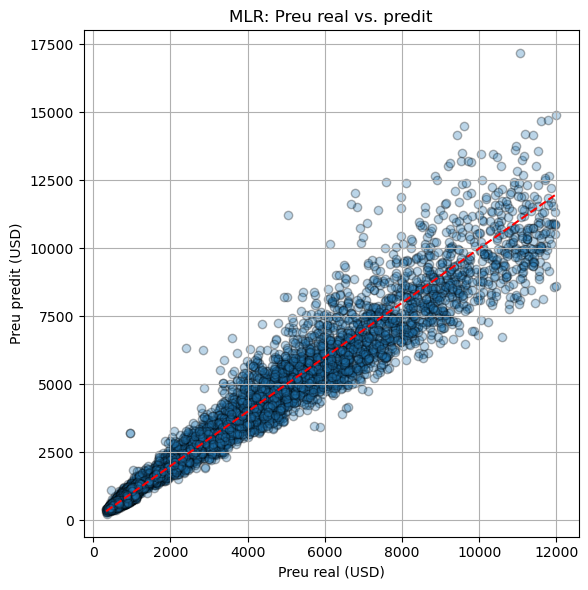

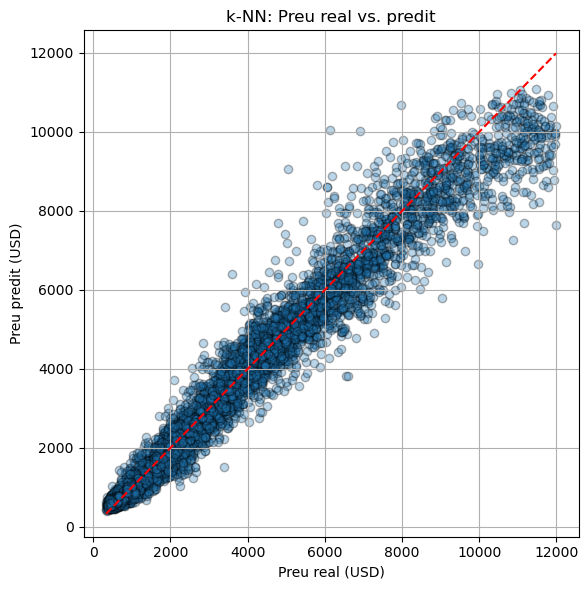

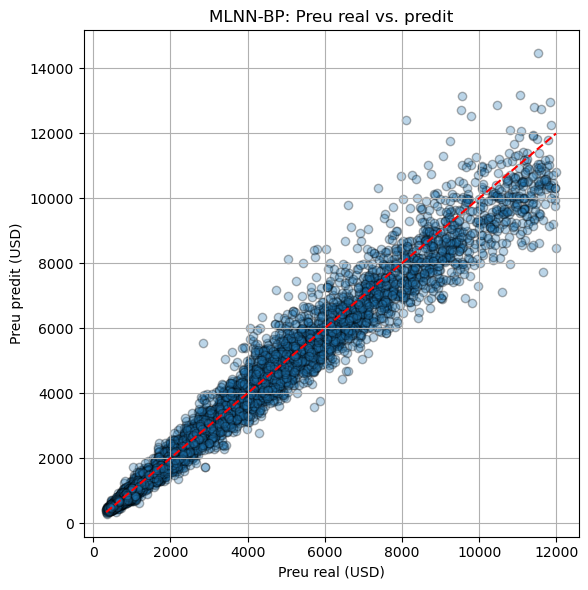

In [28]:
import matplotlib.pyplot as plt

# Funció auxiliar per fer scatter plots
def plot_real_vs_pred(real, pred, title):
    plt.figure(figsize=(6, 6))
    plt.scatter(real, pred, alpha=0.3, edgecolors='k')
    plt.plot([real.min(), real.max()], [real.min(), real.max()], 'r--')
    plt.xlabel("Preu real (USD)")
    plt.ylabel("Preu predit (USD)")
    plt.title(title)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Scatter plot per MLR
plot_real_vs_pred(df_results['price'], df_results['pred_price_mlr'], "MLR: Preu real vs. predit")

# Scatter plot per k-NN
plot_real_vs_pred(df_results['price'], df_results['pred_price_knn'], "k-NN: Preu real vs. predit")

# Scatter plot per MLNN-BP
plot_real_vs_pred(df_results['price'], df_results['pred_price_bp'], "MLNN-BP: Preu real vs. predit")


#### g. Discutiu i elaboreu conclusions a partir dels resultats obtinguts.
